In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

2023-03-03 12:01:21.474053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and Understand Our Data

In [2]:
EPOCHS = 50
BATCH_SIZE = 32

In [3]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 19s 0us/step


In [4]:
print("X Train shape:", x_train.shape)
print(x_train[0][0][0])
print("Looks like we need to convert in between (0,1) by divide elements by 255 \n")
print("Y Train shape:", y_train.shape)
print(np.unique(y_train))
print("Looks like we have 10 unique classes for our data")

X Train shape: (50000, 32, 32, 3)
[59 62 63]
Looks like we need to convert in between (0,1) by divide elements by 255 

Y Train shape: (50000, 1)
[0 1 2 3 4 5 6 7 8 9]
Looks like we have 10 unique classes for our data


In [5]:
# Convert RGB to decimal in between [0,1] => 255 = 1, 0 = 0
x_train, x_test = x_train / 255.0, x_test / 255.0

# Flatten our target dataset
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape)
print("y_train.shape", y_train.shape)

x_train.shape: (50000, 32, 32, 3)
y_train.shape (50000,)


In [6]:
# Get number of target classes
k_class = len(np.unique(y_train))
print("Number of Classes:", k_class)

Number of Classes: 10


### Model

In [7]:
from tensorflow.keras import layers,models,optimizers
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [8]:
# Get input dimension
input_dimension = x_train[0].shape

# Input layer
inputs = Input(shape=input_dimension)
# Maxpooling layer
maxpool = MaxPooling2D((2,2))

# Convolution layers
x = Conv2D(32, (3,3), activation='relu')(inputs)
x = maxpool(x)
# x = Conv2D(32, (3,3), activation='relu')(inputs)
# x = maxpool(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = maxpool(x)
# x = Conv2D(64, (3,3), activation='relu')(x)
# x = maxpool(x)

x = Conv2D(128, (3,3), activation='relu')(x)
x = maxpool(x)

# Fully connected layer
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(k_class, activation='softmax')(x)

model = Model(inputs, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   multiple             0           ['conv2d[0][0]',                 
                                                                  'conv2d_1[0][0]',               
                                                                  'conv2d_2[0][0]']               
                                                                                              

2023-03-03 12:02:07.944903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='SGD', metrics=['accuracy'])

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    width_shift_range=0.1, 
                                    height_shift_range=0.1)

train_generator = data_generator.flow(x_train, y_train, BATCH_SIZE)

steps_per_epoch = x_train.shape[0] // BATCH_SIZE

fitted_model = model.fit(train_generator, 
                         validation_data=(x_test, y_test), 
                         steps_per_epoch=steps_per_epoch, 
                         epochs=EPOCHS)

Epoch 1/50
1562/1562 [==============================] - 51s 32ms/step - loss: 1.6881 - accuracy: 0.3713 - val_loss: 1.4491 - val_accuracy: 0.4703
Epoch 2/50
1562/1562 [==============================] - 54s 35ms/step - loss: 1.3935 - accuracy: 0.4952 - val_loss: 1.3020 - val_accuracy: 0.5318
Epoch 3/50
1562/1562 [==============================] - 54s 34ms/step - loss: 1.2648 - accuracy: 0.5444 - val_loss: 1.2152 - val_accuracy: 0.5672
Epoch 4/50
1562/1562 [==============================] - 55s 35ms/step - loss: 1.1754 - accuracy: 0.5792 - val_loss: 1.0842 - val_accuracy: 0.6125
Epoch 5/50
1562/1562 [==============================] - 54s 35ms/step - loss: 1.1083 - accuracy: 0.6058 - val_loss: 1.0842 - val_accuracy: 0.6167
Epoch 6/50
1562/1562 [==============================] - 53s 34ms/step - loss: 1.0718 - accuracy: 0.6167 - val_loss: 1.0614 - val_accuracy: 0.6294
Epoch 7/50
1562/1562 [==============================] - 54s 35ms/step - loss: 1.0321 - accuracy: 0.6335 - val_loss: 1.0117 -

In [11]:
def plot_acc_and_loss(acc, val_acc, loss, val_loss, epochs_range, condition):
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle("Model: Sparse Categorical Entropy Loss, Adam optimizer, 3 Layers")
    plt.savefig('./{}.png' .format(condition))
    plt.show()

In [14]:
def get_history(fitted_model):
    acc = fitted_model.history['accuracy']
    avg_acc = np.mean(acc)
    val_acc = fitted_model.history['val_accuracy']
    avg_valAcc = np.mean(val_acc)

    loss = fitted_model.history['loss']
    val_loss = fitted_model.history['val_loss']

    print("Average Training accuracy: {:.2f}%".format(avg_acc*100))
    print("Average Validation accuracy: {:.2f}%".format(avg_valAcc*100))

    return acc, val_acc, loss, val_loss


Average Training accuracy: 70.12%
Average Validation accuracy: 69.63%


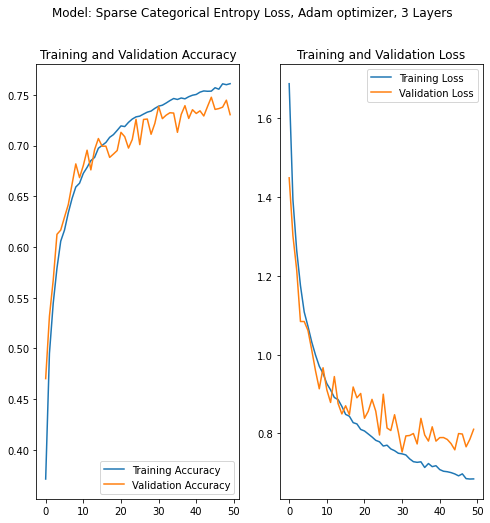

In [17]:
epochs_range = range(EPOCHS)
acc, val_acc, loss, val_loss = get_history(fitted_model)

plot_acc_and_loss(acc, val_acc, loss, val_loss, epochs_range, "Image Augmentation, 50 epochs, SGD")

In [21]:
model.save_weights("model_sgd.h5")